In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{\n  "username": "anastasiasaprina",\n  "key": "KGAT_93b03a40a8fec761f7cec4a29e6e31ef"\n}'}

тут надо подгрузить свой json с токеном кэгла


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets list | head


ref                                                              title                                                  size  lastUpdated                 downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  -----------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
neurocipher/heartdisease                                         Heart Disease                                          3491  2025-12-11 15:29:14.327000           2114         94  1.0              
neurocipher/student-performance                                  Student Performance                                   49705  2025-12-12 12:06:28.973000           1261         70  1.0              
wardabilal/spotify-global-music-dataset-20092025                 Spotify Global Music Dataset (2009–2025)            1289021  2025-11-11 09:43:05.933000          16387        437  1.0              
pranavshin

In [ ]:
!mkdir -p /content/data
%cd /content/data

/content/data


In [ ]:
!kaggle datasets download -d dschettler8845/brats-2021-task1

Dataset URL: https://www.kaggle.com/datasets/dschettler8845/brats-2021-task1
License(s): copyright-authors
100% 12.2G/12.3G [00:37<00:00, 275MB/s]
100% 12.3G/12.3G [00:37<00:00, 355MB/s]


In [ ]:
!unzip -q brats-2021-task1.zip

replace BraTS2021_00495.tar? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace BraTS2021_00621.tar? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace BraTS2021_Training_Data.tar? [y]es, [n]o, [A]ll, [N]one, [r]ename: [n]o
error:  invalid response [[n]o]
replace BraTS2021_Training_Data.tar? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
!tar -xf /content/data/BraTS2021_Training_Data.tar -C /content/data


In [ ]:
import os, random
import numpy as np
import torch

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

use_amp = (device.type == "cuda")
#use_amp = False
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


Using device: cuda


/tmp/ipython-input-1342568858.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


In [ ]:
import json
import os
import numpy as np
from glob import glob

data_root = "/content/data"
split_path = "split_brats2021_whole_tumor.json"


patient_dirs = sorted(
    [p for p in glob(os.path.join(data_root, "*")) if os.path.isdir(p)]
)
patient_ids = [os.path.basename(p) for p in patient_dirs]

print("Patients found:", len(patient_ids))


if os.path.exists(split_path):
    with open(split_path, "r") as f:
        split = json.load(f)
else:
    rng = np.random.default_rng(42)
    perm = rng.permutation(patient_ids)

    n_total = len(perm)
    n_test = int(0.1 * n_total)
    n_val = int(0.2 * n_total)

    test_ids = perm[:n_test].tolist()
    val_ids = perm[n_test:n_test + n_val].tolist()
    train_ids = perm[n_test + n_val:].tolist()

    split = {
        "train": train_ids,
        "val": val_ids,
        "test": test_ids
    }

    with open(split_path, "w") as f:
        json.dump(split, f, indent=2)

train_ids = split["train"]
val_ids = split["val"]
test_ids = split["test"]

print("Train:", len(train_ids))
print("Val:", len(val_ids))
print("Test:", len(test_ids))
print("Total:", len(train_ids) + len(val_ids) + len(test_ids))


Patients found: 1251
Train: 876
Val: 250
Test: 125
Total: 1251


In [ ]:
#files.download("split_brats2021_whole_tumor.json")

In [ ]:
import nibabel as nib
from torch.utils.data import Dataset

class Brats2DWholeTumorDataset(Dataset):
    def __init__(self, data_root, patient_ids, bg_keep_prob=0.2, axis=2, transforms=None):
        self.data_root = data_root
        self.patient_ids = patient_ids
        self.bg_keep_prob = bg_keep_prob
        self.axis = axis
        self.transforms = transforms


        self.items = []
        for pid in self.patient_ids:
            pdir = os.path.join(self.data_root, pid)
            flair = glob(os.path.join(pdir, "*flair*.nii.gz")) + glob(os.path.join(pdir, "*FLAIR*.nii.gz"))
            seg = glob(os.path.join(pdir, "*seg*.nii.gz")) + glob(os.path.join(pdir, "*SEG*.nii.gz"))
            if len(flair) == 0 or len(seg) == 0:
                continue
            self.items.append({"pid": pid, "flair": flair[0], "seg": seg[0]})

        if len(self.items) == 0:
            raise RuntimeError("No valid patients found. Check data_root and file naming.")


        self.epoch_length = len(self.items) * 16

    def __len__(self):
        return self.epoch_length

    @staticmethod
    def _zscore(x, eps=1e-6):
        m = x.mean()
        s = x.std()
        return (x - m) / (s + eps)

    def _get_slice(self, vol, idx):
        if self.axis == 0:
            return vol[idx, :, :]
        if self.axis == 1:
            return vol[:, idx, :]
        return vol[:, :, idx]

    def __getitem__(self, _):

        item = random.choice(self.items)

        flair_3d = nib.load(item["flair"]).get_fdata().astype(np.float32)
        seg_3d = nib.load(item["seg"]).get_fdata().astype(np.int16)


        flair_3d = self._zscore(flair_3d)
        flair_3d = np.nan_to_num(flair_3d, nan=0.0, posinf=0.0, neginf=0.0)



        mask_3d = (seg_3d > 0).astype(np.float32)


        n_slices = flair_3d.shape[self.axis]


        chosen = None
        for _try in range(12):
            idx = random.randrange(n_slices)
            m = self._get_slice(mask_3d, idx)
            if m.sum() > 0:
                chosen = idx
                break

        if chosen is None:

            if random.random() < self.bg_keep_prob:
                chosen = random.randrange(n_slices)
            else:

                while True:
                    idx = random.randrange(n_slices)
                    m = self._get_slice(mask_3d, idx)
                    if m.sum() > 0:
                        chosen = idx
                        break

        img2d = self._get_slice(flair_3d, chosen)
        msk2d = self._get_slice(mask_3d, chosen)


        img2d = img2d[None, ...]
        msk2d = msk2d[None, ...]

        sample = {"image": img2d, "mask": msk2d, "pid": item["pid"], "slice": chosen}

        if self.transforms is not None:
            sample = self.transforms(sample)


        image = torch.from_numpy(sample["image"]).float()
        mask = torch.from_numpy(sample["mask"]).float()
        return image, mask


In [ ]:
from torch.utils.data import DataLoader

train_ds = Brats2DWholeTumorDataset(
    data_root=data_root,
    patient_ids=train_ids,
    bg_keep_prob=0.15,
    axis=2,
    transforms=None
)

val_ds = Brats2DWholeTumorDataset(
    data_root=data_root,
    patient_ids=val_ids,
    bg_keep_prob=1.0,
    axis=2,
    transforms=None
)

test_ds = Brats2DWholeTumorDataset(
    data_root=data_root,
    patient_ids=test_ids,
    bg_keep_prob=1.0,
    axis=2,
    transforms=None
)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)


In [ ]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 44.7 MB/s eta 0:00:00


In [ ]:
import torch.nn.functional as F
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric

model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

loss_fn = DiceLoss(sigmoid=True)
dice_metric = DiceMetric(include_background=True, reduction="mean")

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)


<frozen importlib._bootstrap_external>:1301: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.


In [ ]:
save_path = "/content/drive/MyDrive/brats/unet2d_flair_whole_tumor_best.pt"

In [ ]:
from tqdm import tqdm
from torch import amp

def evaluate(model, loader):
    model.eval()
    dice_metric.reset()
    val_loss = 0.0
    n = 0

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)

            with amp.autocast(device_type="cuda", dtype=torch.bfloat16, enabled=use_amp):
                logits = model(images)
                loss = loss_fn(logits, masks)

            val_loss += loss.item() * images.size(0)
            n += images.size(0)

            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
            dice_metric(y_pred=preds, y=masks)

    mean_dice = dice_metric.aggregate().item()
    return val_loss / max(n, 1), mean_dice


best_dice = -1.0
epochs = 6
save_path = save_path

for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0.0
    n = 0

    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}"):
        images = images.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with amp.autocast(device_type="cuda", dtype=torch.bfloat16, enabled=use_amp):
            logits = model(images)
            loss = loss_fn(logits, masks)

        """
        if not torch.isfinite(loss):
            print("Non-finite loss!")
            print("images finite:", torch.isfinite(images).all().item())
            print("masks finite:", torch.isfinite(masks).all().item())
            print("images min/max:", images.min().item(), images.max().item())
            print("masks unique:", torch.unique(masks).cpu().numpy()[:10])
            print("logits finite:", torch.isfinite(logits).all().item())
            print("logits min/max:", logits.min().item(), logits.max().item())
            break
        """

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()


        train_loss += loss.item() * images.size(0)
        n += images.size(0)

    train_loss /= max(n, 1)
    val_loss, val_dice = evaluate(model, val_loader)

    print(f"Epoch {epoch}: train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_dice={val_dice:.4f}")

    if val_dice > best_dice:
        best_dice = val_dice

        checkpoint = {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scaler_state_dict": scaler.state_dict() if use_amp else None,
            "val_dice": val_dice,
        }

        torch.save(checkpoint, save_path)
        print(f"Saved best model checkpoint: Dice={best_dice:.4f}")



# load best checkpoint
ckpt = torch.load(save_path, map_location=device)
model.load_state_dict(ckpt["model_state_dict"])


test_loss, test_dice = evaluate(model, test_loader)
print(f"TEST: loss={test_loss:.4f} | dice={test_dice:.4f} (best val dice={ckpt['val_dice']:.4f} at epoch {ckpt['epoch']})")



Epoch 1/6: 100%|██████████| 876/876 [33:58<00:00,  2.33s/it]


Epoch 1: train_loss=0.2921 | val_loss=0.2701 | val_dice=0.7410
Saved best model checkpoint: Dice=0.7410


Epoch 2/6: 100%|██████████| 876/876 [34:31<00:00,  2.36s/it]


Epoch 2: train_loss=0.2312 | val_loss=0.2432 | val_dice=0.7633
Saved best model checkpoint: Dice=0.7633


Epoch 3/6: 100%|██████████| 876/876 [34:35<00:00,  2.37s/it]


Epoch 3: train_loss=0.2180 | val_loss=0.2421 | val_dice=0.7652
Saved best model checkpoint: Dice=0.7652


Epoch 4/6: 100%|██████████| 876/876 [34:20<00:00,  2.35s/it]


Epoch 4: train_loss=0.2076 | val_loss=0.2302 | val_dice=0.7770
Saved best model checkpoint: Dice=0.7770


Epoch 5/6: 100%|██████████| 876/876 [34:35<00:00,  2.37s/it]


Epoch 5: train_loss=0.2007 | val_loss=0.2246 | val_dice=0.7817
Saved best model checkpoint: Dice=0.7817


Epoch 6/6:  50%|████▉     | 436/876 [17:11<17:10,  2.34s/it]

In [ ]:
#rm -f unet2d_flair_whole_tumor_best.pt

In [ ]:
ckpt_path = "/content/drive/MyDrive/brats/unet2d_flair_whole_tumor_best.pt"


In [ ]:
import torch
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

loss_fn = DiceLoss(sigmoid=True)
dice_metric = DiceMetric(include_background=True, reduction="mean")

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

use_amp = torch.cuda.is_available()
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


/tmp/ipython-input-2122120143.py:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


In [ ]:
ckpt_path = ckpt_path
ckpt = torch.load(ckpt_path, map_location=device)

model.load_state_dict(ckpt["model_state_dict"])
optimizer.load_state_dict(ckpt["optimizer_state_dict"])

if use_amp and ckpt.get("scaler_state_dict") is not None:
    scaler.load_state_dict(ckpt["scaler_state_dict"])

start_epoch = ckpt["epoch"]
best_dice = ckpt.get("val_dice", -1.0)

print("Resumed from epoch:", start_epoch)
print("Best val dice so far:", best_dice)


Resumed from epoch: 10
Best val dice so far: 0.794410765171051


In [ ]:
from tqdm import tqdm
from torch import amp

def evaluate(model, loader):
    model.eval()
    dice_metric.reset()
    val_loss = 0.0
    n = 0

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)

            with amp.autocast(device_type="cuda", dtype=torch.bfloat16, enabled=use_amp):
                logits = model(images)
                loss = loss_fn(logits, masks)

            val_loss += loss.item() * images.size(0)
            n += images.size(0)

            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
            dice_metric(y_pred=preds, y=masks)

    mean_dice = dice_metric.aggregate().item()
    return val_loss / max(n, 1), mean_dice


best_dice = -1.0
epochs = 10
save_path = save_path

for epoch in range(start_epoch, epochs + 1):
    model.train()
    train_loss = 0.0
    n = 0

    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}"):
        images = images.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with amp.autocast(device_type="cuda", dtype=torch.bfloat16, enabled=use_amp):
            logits = model(images)
            loss = loss_fn(logits, masks)

        """
        if not torch.isfinite(loss):
            print("Non-finite loss!")
            print("images finite:", torch.isfinite(images).all().item())
            print("masks finite:", torch.isfinite(masks).all().item())
            print("images min/max:", images.min().item(), images.max().item())
            print("masks unique:", torch.unique(masks).cpu().numpy()[:10])
            print("logits finite:", torch.isfinite(logits).all().item())
            print("logits min/max:", logits.min().item(), logits.max().item())
            break
        """

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()


        train_loss += loss.item() * images.size(0)
        n += images.size(0)

    train_loss /= max(n, 1)
    val_loss, val_dice = evaluate(model, val_loader)

    print(f"Epoch {epoch}: train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_dice={val_dice:.4f}")

    if val_dice > best_dice:
        best_dice = val_dice

        checkpoint = {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scaler_state_dict": scaler.state_dict() if use_amp else None,
            "val_dice": val_dice,
        }

        torch.save(checkpoint, save_path)
        print(f"Saved best model checkpoint: Dice={best_dice:.4f}")



# load best checkpoint
ckpt = torch.load(save_path, map_location=device)
model.load_state_dict(ckpt["model_state_dict"])


test_loss, test_dice = evaluate(model, test_loader)
print(f"TEST: loss={test_loss:.4f} | dice={test_dice:.4f} (best val dice={ckpt['val_dice']:.4f} at epoch {ckpt['epoch']})")



Epoch 10/10: 100%|██████████| 876/876 [35:48<00:00,  2.45s/it]


Epoch 10: train_loss=0.1758 | val_loss=0.2012 | val_dice=0.8040
Saved best model checkpoint: Dice=0.8040
TEST: loss=0.1867 | dice=0.8155 (best val dice=0.8040 at epoch 10)


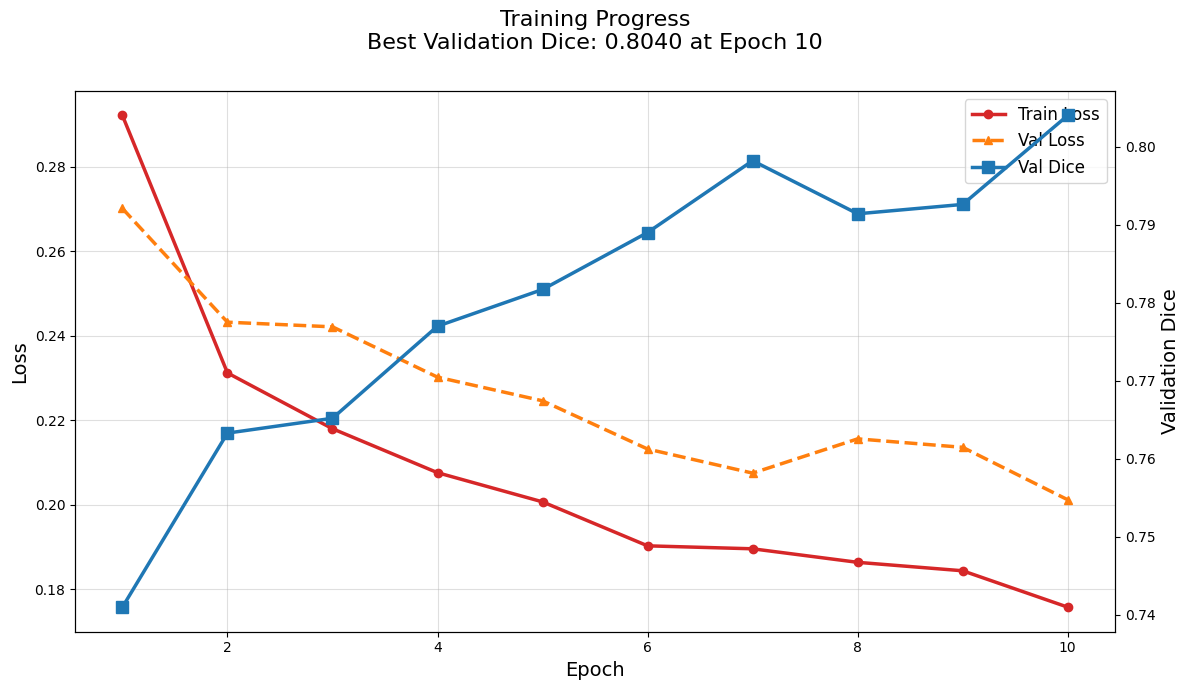

In [2]:
import matplotlib.pyplot as plt

history = {
    "train_loss": [0.2921, 0.2312, 0.2180, 0.2076, 0.2007, 0.1903, 0.1896, 0.1864, 0.1844, 0.1758],
    "val_loss": [0.2701, 0.2432, 0.2421, 0.2302, 0.2246, 0.2132, 0.2075, 0.2156, 0.2136, 0.2012],
    "val_dice": [0.7410, 0.7633, 0.7652, 0.7770, 0.7817, 0.7890, 0.7982, 0.7914, 0.7926, 0.8040]
}

# Extract data from history (after training)
epochs = list(range(1, len(history["train_loss"]) + 1))

best_dice = max(history["val_dice"])
best_epoch = history["val_dice"].index(best_dice) + 1

# Single plot with dual axes
fig, ax1 = plt.subplots(figsize=(12, 7))

# Losses on left y-axis
ax1.set_xlabel('Epoch', fontsize=14)
ax1.set_ylabel('Loss', fontsize=14)
ax1.plot(epochs, history["train_loss"], 'o-', color='tab:red', linewidth=2.5, label='Train Loss')
ax1.plot(epochs, history["val_loss"], '^--', color='tab:orange', linewidth=2.5, label='Val Loss')
ax1.tick_params(axis='y')
ax1.grid(True, alpha=0.4)

# Validation Dice on right y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Validation Dice', fontsize=14)
ax2.plot(epochs, history["val_dice"], 's-', color='tab:blue', linewidth=2.5, markersize=8, label='Val Dice')
ax2.tick_params(axis='y')

# Title and combined legend
plt.title(f'Training Progress\n'
          f'Best Validation Dice: {best_dice:.4f} at Epoch {best_epoch}',
          fontsize=16, pad=30)

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=12)

fig.tight_layout()
plt.show()